In [1]:
import pandas as pd
from datetime import datetime
import pylab as plt
import numpy as np
import glob
import os
import sys
import matplotlib
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy.ma as ma

In [2]:
data_path = r"/home/znjs2/input_data/atom_data_02_20/processed/all_atom_ch4_data"
outfile = '/home/znjs2/output/vertical_profiles'

In [3]:
loc_data = pd.read_csv(data_path, delimiter=',', 
                        na_values = [-99999, -9999, -999, -888], 
                        parse_dates=[0], 
                        index_col=0,
                        usecols = ['UTC_Start','G_LAT','G_LONG','G_ALT','CH4_PECD'])

print(loc_data.iloc[:3])

              G_LAT     G_LONG  G_ALT  CH4_PECD
UTC_Start                                      
73265.0   -43.47749  172.54577   88.7       NaN
73266.0   -43.47688  172.54648   98.1       NaN
73267.0   -43.47627  172.54718  108.3       NaN


In [4]:
#select only rows with non nan ch4 data
meas_path = loc_data.dropna(subset=['CH4_PECD'])
print(meas_path.shape)

(7208, 4)


## Plots of flight paths

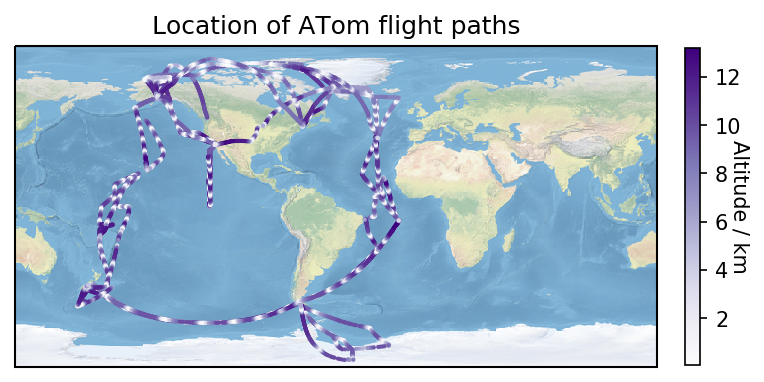

In [5]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-50))
#ax.coastlines(linewidth=0.5)
ax.stock_img()
ax.set_extent([150, 0, -90, 90])

#ax.set_xlim(0,360)
plt.scatter(meas_path.iloc[:,1]+50,meas_path.iloc[:,0], s=1, c=meas_path.iloc[:,2]/1000, cmap='Purples')

cbar = plt.colorbar(shrink = 0.7,fraction = 0.04, pad=0.04)
cbar.set_label('Altitude / km', rotation = 270)
plt.title('Location of ATom flight paths')
plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

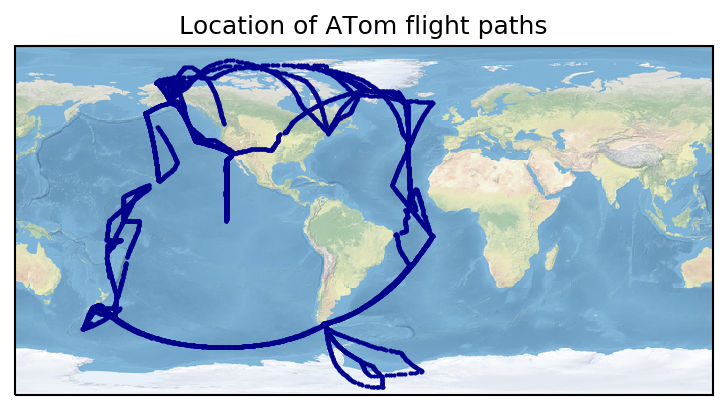

In [6]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=310.0))
#ax.coastlines()
ax.stock_img()
#ax.set_xlim(200,360)
plt.scatter(meas_path.iloc[:,1]+50,meas_path.iloc[:,0], s=1, c='darkblue')

plt.title('Location of ATom flight paths')
plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

## Bin latitudes to model grid (test)

In [7]:
lat_all = list(range(-90,91,10))
lon_all = list(range(-180,181,10))

[-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[-180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]


In [8]:
lats = np.empty(len(meas_path))

#put all ATom data into lat bins
for i in range(len(meas_path)):
    for ind1 in range(len(lat_all)):
        lat_val = meas_path.iloc[i,0]
        if lat_val >= lat_all[ind1] and lat_val <= lat_all[ind1+1]:
            #print(meas_path.iloc[i,0])
            lats[i] = lat_all[ind1]+5
            #print(lat_all[ind1]+5)

In [9]:
lons = np.empty(len(meas_path))

#put all ATom data into lon bins
for i in range(len(meas_path)):
    for ind2 in range(len(lon_all)):
        lon_val = meas_path.iloc[i,1]
        if lon_val >= lon_all[ind2] and lon_val <= lon_all[ind2+1]:
            lons[i] = lon_all[ind2]+5

## Locations of ATom measurement

Text(0.5, 1.0, 'ATom measurement range')

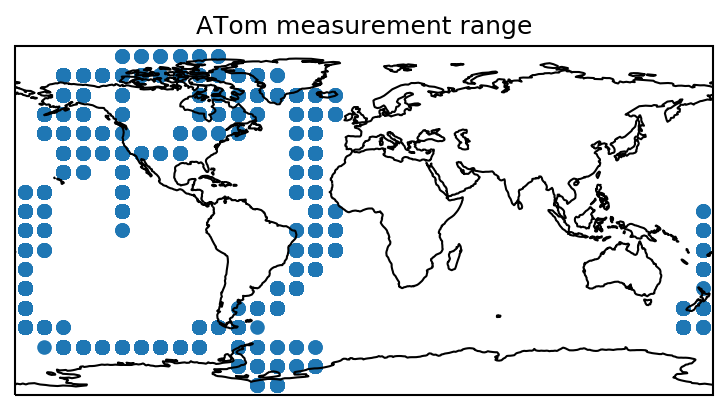

In [176]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#cmap = matplotlib.cm.get_cmap('viridis')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
ax.coastlines()
plot = ax.scatter(lons,lats)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Make masked array

In [38]:
#arrays of grid bin centres
centr_lats = np.array(list(range(-85,91,5)))
centr_lons = np.array(list(range(-175,181,5)))

In [42]:
#make correct shape array of lats and lons
globe_lats = np.transpose(np.array([centr_lats]*72))
print(globe_lats.shape)

globe_lons = np.array([centr_lons]*36)
print(globe_lons.shape)

(36, 72)
(36, 72)


In [43]:
meas_loc = pd.DataFrame({'lon':lons,'lat':lats})

In [44]:
glob_mask = np.ones((len(centr_lats),len(centr_lons))) 

for row in range(len(meas_loc)): 
    #cond = globe_lats == meas_loc.iloc[m,1]) and (globe_lons == meas_loc.iloc[m,0] 
    lat_val = meas_loc.iloc[row,1] 
    lon_val = meas_loc.iloc[row,0] 
    glob_mask1 = ma.masked_where(globe_lats == lat_val,glob_mask) 
    glob_mask2 = ma.masked_where(globe_lons == lon_val,glob_mask) 
    glob_mask3 = ma.masked_where(glob_mask1.mask * glob_mask2.mask, glob_mask) 
    glob_mask = glob_mask3

Text(0.5, 1.0, 'ATom measurement range')

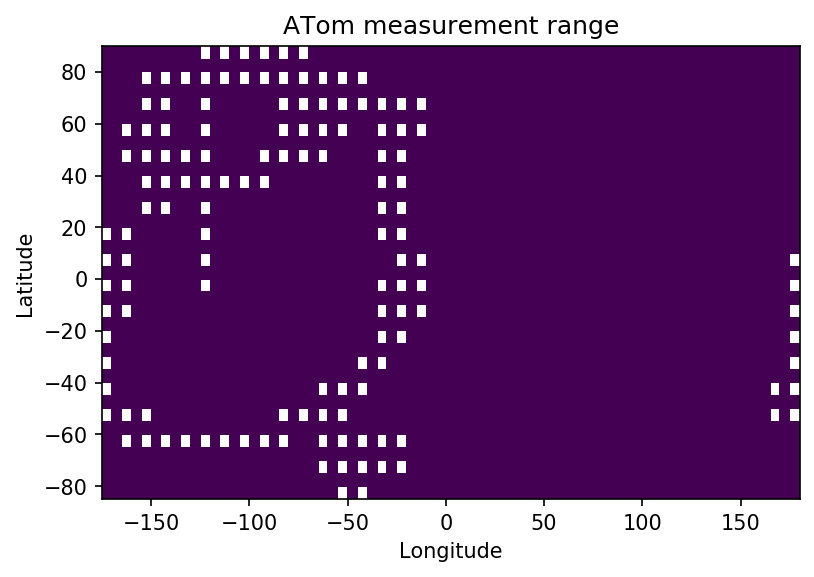

In [46]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#plt.pcolormesh(centr_lons,centr_lats,lat_mask1)
plt.pcolormesh(centr_lons,centr_lats,glob_mask)

#ax.set_xlim(150,180)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Actual model lat lon array

In [ ]:
#define model lat and lons (N96) from xltln data
#data = nc.Dataset(f'/shared/netscratch/ptg21/UM_data/xltln/xltln_ch4.nc')
#mod_lat = data.variables['latitude'][:]
#mod_lon = data.variables['longitude'][:]

In [142]:
mod_lat = list(np.arange(-90,91,2.5))
mod_lon = np.array(np.arange(0,361,3.75))
meas_path['lon_0'] = meas_path['G_LONG']+180

/home/znjs2/.conda/envs/basemap/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Bin latitudes to model values

In [109]:
lats_n96 = np.empty(len(meas_path))

#put all ATom data into lat bins
for i in range(len(meas_path)):
    for ind1 in range(len(mod_lat)):
        lat_val = meas_path.iloc[i,0]
        if lat_val >= mod_lat[ind1] and lat_val <= mod_lat[ind1+1]:
            #print('lat')
            #print(meas_path.iloc[i,0])
            lats_n96[i] = mod_lat[ind1]
            #print(mod_lat[ind1])
        else:
            pass

[-45. -45. -45. ...  -5.  -5.  -5.]


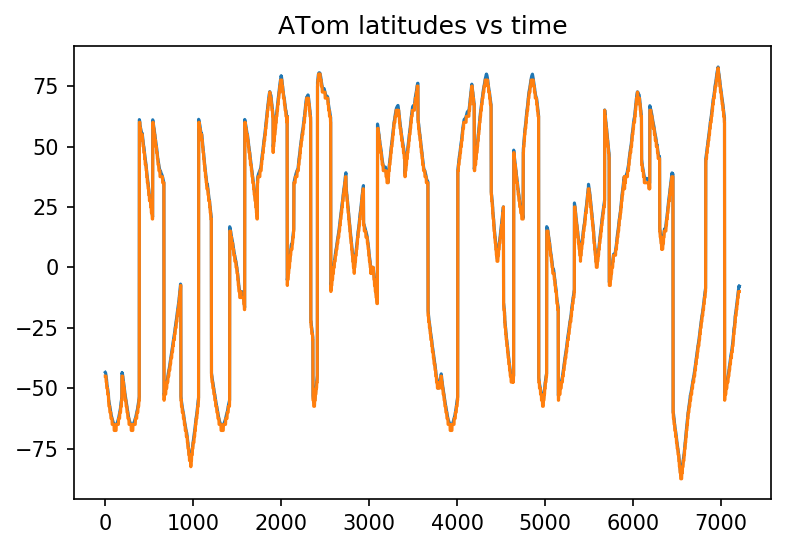

In [129]:
print(lats)
fig = plt.figure(dpi=150)
ax = plt.axes()

x_vals = list(range(len(meas_path)))

plt.plot(x_vals,meas_path.iloc[:,0])
plt.plot(lats_n96)

#ax.set_ylim(-44,-46)
#ax.set_xlim(0,100)

plt.title('ATom latitudes vs time')
#plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

## Bin longitudes to model values

In [120]:
lons_n96 = np.empty(len(meas_path))

#put all ATom data into lon bins
for i in range(len(meas_path)):
    for ind2 in range(len(mod_lon)):
        lon_val = meas_path.iloc[i,1]+180 #measured go from -180
        if lon_val >= mod_lon[ind2] and lon_val <= mod_lon[ind2]+3.75:#lon interval
            #print('lat')
            #print(lon_val)
            #print(mod_lon[ind2])
            lons_n96[i] = mod_lon[ind2]
        else:
            pass

lat
352.78643999999997
352.5
lat
353.03391000000005
352.5
lat
353.31179
352.5
lat
353.64229
352.5
lat
354.29078000000004
352.5
lat
354.47927000000004
352.5
lat
354.68363
352.5
lat
354.89707
352.5
lat
355.34388
352.5
lat
355.57856000000004
352.5
lat
355.8071
352.5
lat
356.03954
352.5
lat
356.5111
356.25
lat
356.74753
356.25
lat
356.98949
356.25
lat
357.23978
356.25
lat
358.33307
356.25
lat
358.62108
356.25
lat
359.21389
356.25
lat
359.51931
356.25
lat
359.80030999999997
356.25
lat
0.043299999999987904
0.0
lat
0.5140199999999879
0.0
lat
0.7470700000000079
0.0
lat
0.9764700000000062
0.0
lat
1.2025899999999865
0.0
lat
1.6415800000000047
0.0
lat
1.8444899999999507
0.0
lat
2.059570000000008
0.0
lat
2.313430000000011
0.0
lat
2.8760800000000017
0.0
lat
3.1786299999999983
0.0
lat
3.4942899999999497
0.0
lat
3.8251800000000458
3.75
lat
4.519069999999999
3.75
lat
4.892710000000051
3.75
lat
5.275650000000013
3.75
lat
6.849670000000003
3.75
lat
7.252620000000007
3.75
lat
8.943479999999994
7.5
lat
9.

lat
96.59316
93.75
lat
96.93294
93.75
lat
97.53435
97.5
lat
97.83518000000002
97.5
lat
98.17246
97.5
lat
98.52263
97.5
lat
99.30683
97.5
lat
99.72543
97.5
lat
100.16736
97.5
lat
100.62601
97.5
lat
101.5234
101.25
lat
101.96309000000002
101.25
lat
102.39711
101.25
lat
102.82859
101.25
lat
103.68963000000002
101.25
lat
104.11451
101.25
lat
104.53055
101.25
lat
104.94664
101.25
lat
105.76281
105.0
lat
106.16492
105.0
lat
106.56473000000003
105.0
lat
106.96186999999998
105.0
lat
107.72238
105.0
lat
107.9887
105.0
lat
108.24404
105.0
lat
108.48552
105.0
lat
108.92406
108.75
lat
29.97328999999999
26.25
lat
29.795620000000014
26.25
lat
29.681479999999993
26.25
lat
29.066630000000004
26.25
lat
28.67347000000001
26.25
lat
28.274930000000012
26.25
lat
27.872800000000012
26.25
lat
24.461029999999994
22.5
lat
24.098520000000008
22.5
lat
23.74091999999999
22.5
lat
23.0368
22.5
lat
22.68808999999999
22.5
lat
22.344139999999953
18.75
lat
22.006969999999995
18.75
lat
21.344009999999997
18.75
lat
21.01

lat
115.79284
112.5
lat
116.13314
112.5
lat
116.72409999999999
116.25
lat
116.99654000000001
116.25
lat
117.26321999999999
116.25
lat
117.52843000000001
116.25
lat
118.03064
116.25
lat
118.27138000000001
116.25
lat
118.51612
116.25
lat
118.79935
116.25
lat
119.3991
116.25
lat
119.71996
116.25
lat
120.05199
120.0
lat
121.06474
120.0
lat
121.40723
120.0
lat
121.75343000000001
120.0
lat
122.11016000000001
120.0
lat
122.83386999999999
120.0
lat
123.18954
120.0
lat
123.52445
120.0
lat
123.81506999999999
123.75
lat
124.31629000000001
123.75
lat
124.54894
123.75
lat
124.77608000000001
123.75
lat
124.99736
123.75
lat
125.4125
123.75
lat
125.60130000000001
123.75
lat
125.78678000000001
123.75
lat
126.01241
123.75
lat
126.78963
123.75
lat
127.07218
123.75
lat
127.34574
123.75
lat
127.93272999999999
127.5
lat
128.21546
127.5
lat
128.48467
127.5
lat
128.75753
127.5
lat
129.33427
127.5
lat
129.62507
127.5
lat
129.9322
127.5
lat
130.25045
127.5
lat
130.8846
127.5
lat
131.19805
127.5
lat
131.50822
13

lat
110.17544000000001
108.75
lat
110.04467
108.75
lat
29.81523999999999
26.25
lat
29.622810000000044
26.25
lat
29.41783000000001
26.25
lat
29.157339999999948
26.25
lat
28.51692
26.25
lat
28.114069999999998
26.25
lat
27.704139999999995
26.25
lat
27.284449999999993
26.25
lat
26.435860000000048
26.25
lat
26.005079999999992
22.5
lat
25.572699999999998
22.5
lat
25.141699999999986
22.5
lat
24.301680000000005
22.5
lat
23.88463999999999
22.5
lat
23.470789999999994
22.5
lat
23.083110000000005
22.5
lat
22.36500000000001
18.75
lat
21.680509999999998
18.75
lat
21.348129999999998
18.75
lat
20.693719999999956
18.75
lat
20.371620000000007
18.75
lat
20.052260000000047
18.75
lat
19.73576
18.75
lat
19.145989999999955
18.75
lat
18.864280000000008
18.75
lat
18.598450000000014
15.0
lat
18.344979999999993
15.0
lat
17.679149999999993
15.0
lat
17.513350000000003
15.0
lat
17.34951000000001
15.0
lat
17.19796000000005
15.0
lat
17.254559999999998
15.0
lat
17.36421999999999
15.0
lat
17.196560000000005
15.0
lat
17

lat
95.42653
93.75
lat
95.80388
93.75
lat
96.64386
93.75
lat
97.07857
93.75
lat
97.52568000000002
97.5
lat
97.97314
97.5
lat
98.85804
97.5
lat
99.30144
97.5
lat
99.74916999999998
97.5
lat
100.19283
97.5
lat
101.03566
97.5
lat
101.4114
101.25
lat
101.7503
101.25
lat
102.05825
101.25
lat
102.63123
101.25
lat
102.88843
101.25
lat
103.1197
101.25
lat
103.34397
101.25
lat
103.78822
101.25
lat
104.05158
101.25
lat
104.33623
101.25
lat
104.63795999999998
101.25
lat
105.35696999999998
105.0
lat
105.79120999999998
105.0
lat
106.24124
105.0
lat
106.69398000000002
105.0
lat
19.17098999999999
18.75
lat
18.966669999999993
18.75
lat
18.777829999999994
18.75
lat
18.603999999999957
15.0
lat
18.279629999999997
15.0
lat
18.119259999999997
15.0
lat
17.95240000000001
15.0
lat
17.77413999999999
15.0
lat
17.376019999999954
15.0
lat
17.150810000000007
15.0
lat
16.92541
15.0
lat
16.69810000000001
15.0
lat
16.22323
15.0
lat
15.979560000000049
15.0
lat
15.731260000000049
15.0
lat
15.483100000000007
15.0
lat
14.

lat
23.34176000000005
22.5
lat
23.399730000000005
22.5
lat
23.45774
22.5
lat
23.571709999999996
22.5
lat
23.630079999999992
22.5
lat
23.685100000000006
22.5
lat
23.73872
22.5
lat
23.843500000000006
22.5
lat
23.892470000000003
22.5
lat
23.937369999999987
22.5
lat
23.982850000000013
22.5
lat
57.212689999999995
56.25
lat
56.91266
56.25
lat
56.3014
56.25
lat
55.99511
52.5
lat
55.693740000000005
52.5
lat
55.39528
52.5
lat
54.7987
52.5
lat
54.49799
52.5
lat
54.195130000000006
52.5
lat
53.890280000000004
52.5
lat
53.279529999999994
52.5
lat
52.969229999999996
52.5
lat
52.65052
52.5
lat
52.333110000000005
48.75
lat
51.77484999999999
48.75
lat
51.517510000000016
48.75
lat
51.26634999999999
48.75
lat
51.01671999999999
48.75
lat
50.53697
48.75
lat
50.32974999999999
48.75
lat
50.12008
48.75
lat
49.92238999999998
48.75
lat
49.47058999999999
48.75
lat
49.2071
48.75
lat
48.92917
48.75
lat
48.640209999999996
45.0
lat
48.03104999999999
45.0
lat
47.698769999999996
45.0
lat
47.35925
45.0
lat
47.013360000

lat
31.854610000000008
30.0
lat
31.876480000000043
30.0
lat
31.916960000000046
30.0
lat
31.933729999999997
30.0
lat
31.970380000000006
30.0
lat
32.25766999999999
30.0
lat
32.28136999999995
30.0
lat
32.10013999999995
30.0
lat
31.85327000000001
30.0
lat
31.51523999999995
30.0
lat
31.082960000000014
30.0
lat
30.918679999999995
30.0
lat
30.75708999999995
30.0
lat
30.605339999999956
30.0
lat
30.33590000000001
30.0
lat
30.205560000000048
30.0
lat
30.082239999999956
30.0
lat
29.920819999999992
26.25
lat
29.987610000000046
26.25
lat
29.69966000000005
26.25
lat
29.671120000000002
26.25
lat
29.98812000000001
26.25
lat
163.67034
161.25
lat
163.59777
161.25
lat
163.5279
161.25
lat
163.46055
161.25
lat
163.3276
161.25
lat
163.2617
161.25
lat
163.19778
161.25
lat
163.14311
161.25
lat
163.04405
161.25
lat
162.98943
161.25
lat
162.92637
161.25
lat
162.86052
161.25
lat
162.71469
161.25
lat
162.63467
161.25
lat
162.55529
161.25
lat
162.47523999999999
161.25
lat
162.31091
161.25
lat
162.22926
161.25
lat


lat
346.21604
345.0
lat
346.64484
345.0
lat
346.86321999999996
345.0
lat
347.07568999999995
345.0
lat
347.28359
345.0
lat
347.69317
345.0
lat
347.8931
345.0
lat
348.08936
345.0
lat
348.28301000000005
345.0
lat
348.66217
345.0
lat
348.84829
348.75
lat
349.03159
348.75
lat
349.21265
348.75
lat
349.5707100000001
348.75
lat
349.74857
348.75
lat
349.92533999999995
348.75
lat
350.10152
348.75
lat
350.45447
348.75
lat
350.62827
348.75
lat
350.79705
348.75
lat
350.96376
348.75
lat
351.29174
348.75
lat
351.45263
348.75
lat
351.60963999999996
348.75
lat
351.76706
348.75
lat
110.46342
108.75
lat
110.26113000000001
108.75
lat
110.28258000000001
108.75
lat
110.30842
108.75
lat
110.36733000000001
108.75
lat
110.40204
108.75
lat
110.4388
108.75
lat
110.4784
108.75
lat
110.56185
108.75
lat
110.60937
108.75
lat
110.65829000000001
108.75
lat
110.71021999999999
108.75
lat
108.82181
108.75
lat
107.27020999999998
105.0
lat
105.69906999999998
105.0
lat
104.11153
101.25
lat
100.85082
97.5
lat
99.187390000000

lat
58.999359999999996
56.25
lat
58.999449999999996
56.25
lat
58.999970000000005
56.25
lat
58.99946
56.25
lat
58.999939999999995
56.25
lat
58.99991
56.25
lat
58.99995
56.25
lat
58.999359999999996
56.25
lat
58.999939999999995
56.25
lat
58.99992
56.25
lat
58.999979999999994
56.25
lat
58.99935000000001
56.25
lat
58.999359999999996
56.25
lat
58.99937
56.25
lat
58.99946
56.25
lat
58.999840000000006
56.25
lat
58.99942
56.25
lat
58.99938
56.25
lat
58.999970000000005
56.25
lat
58.99992
56.25
lat
58.99995
56.25
lat
58.999430000000004
56.25
lat
58.999960000000016
56.25
lat
58.999399999999994
56.25
lat
58.99987
56.25
lat
58.99991
56.25
lat
58.99999
56.25
lat
58.976169999999996
56.25
lat
58.86606999999999
56.25
lat
58.739630000000005
56.25
lat
58.58284999999999
56.25
lat
58.42716
56.25
lat
58.36444
56.25
lat
58.36846
56.25
lat
58.36515
56.25
lat
58.39978000000001
56.25
lat
58.698539999999994
56.25
lat
58.84457999999999
56.25
lat
58.97538
56.25
lat
58.999939999999995
56.25
lat
59.16923
56.25
lat
59

lat
10.146360000000044
7.5
lat
10.079880000000003
7.5
lat
9.98075
7.5
lat
9.805019999999956
7.5
lat
9.689390000000003
7.5
lat
9.575760000000002
7.5
lat
9.703519999999997
7.5
lat
9.418189999999953
7.5
lat
33.73786999999999
30.0
lat
33.930710000000005
33.75
lat
34.116240000000005
33.75
lat
34.26911999999999
33.75
lat
34.526729999999986
33.75
lat
34.653130000000004
33.75
lat
34.77815000000001
33.75
lat
34.89789999999999
33.75
lat
35.12912
33.75
lat
35.24305000000001
33.75
lat
35.36139
33.75
lat
35.47798
33.75
lat
35.7312
33.75
lat
35.8638
33.75
lat
36.14975000000001
33.75
lat
36.441569999999956
33.75
lat
36.59440000000001
33.75
lat
36.753439999999955
33.75
lat
36.91571000000005
33.75
lat
37.23537999999999
33.75
lat
37.39022
33.75
lat
37.54218999999995
37.5
lat
37.69154
37.5
lat
37.992230000000006
37.5
lat
38.137370000000004
37.5
lat
38.282849999999996
37.5
lat
38.42517000000001
37.5
lat
38.70129
37.5
lat
38.83573999999999
37.5
lat
38.959010000000006
37.5
lat
39.063559999999995
37.5
lat
39

lat
152.26282
150.0
lat
152.23486
150.0
lat
152.17913
150.0
lat
152.14949000000001
150.0
lat
152.11643
150.0
lat
152.08082
150.0
lat
152.00594
150.0
lat
151.96759
150.0
lat
151.92974
150.0
lat
151.88859
150.0
lat
151.81631
150.0
lat
151.78245
150.0
lat
151.74942
150.0
lat
151.71695
150.0
lat
151.66217
150.0
lat
151.63153
150.0
lat
151.59686
150.0
lat
151.56154
150.0
lat
151.48158
150.0
lat
151.43855
150.0
lat
151.39484
150.0
lat
151.34781
150.0
lat
151.24924
150.0
lat
151.19928
150.0
lat
151.14822
150.0
lat
151.09620999999999
150.0
lat
150.97454
150.0
lat
150.83089
150.0
lat
150.68633
150.0
lat
150.55172
150.0
lat
150.31289
150.0
lat
150.19487
150.0
lat
150.07728
150.0
lat
149.96317
146.25
lat
149.74905
146.25
lat
149.64099
146.25
lat
149.51028
146.25
lat
149.3773
146.25
lat
149.08395000000002
146.25
lat
148.9257
146.25
lat
148.75292
146.25
lat
148.57297
146.25
lat
148.21215
146.25
lat
148.03346
146.25
lat
147.84978
146.25
lat
147.57063
146.25
lat
146.37564
146.25
lat
145.7819099999999

lat
355.24295
352.5
lat
354.85994
352.5
lat
354.48253
352.5
lat
354.10938000000004
352.5
lat
352.96442
352.5
lat
352.58097
352.5
lat
351.44282999999996
348.75
lat
351.08493
348.75
lat
350.75281
348.75
lat
350.44093999999996
348.75
lat
350.10231000000005
348.75
lat
350.0132
348.75
lat
349.92665999999997
348.75
lat
349.84344999999996
348.75
lat
349.68665
348.75
lat
349.61525
348.75
lat
349.54172
348.75
lat
349.51281
348.75
lat
349.82786999999996
348.75
lat
350.00184
348.75
lat
350.20049
348.75
lat
350.43367
348.75
lat
354.5906
352.5
lat
354.76633000000004
352.5
lat
355.16328999999996
352.5
lat
355.37977
352.5
lat
355.5972
352.5
lat
356.28905
356.25
lat
356.54076
356.25
lat
356.79341999999997
356.25
lat
357.04641000000004
356.25
lat
357.57036000000005
356.25
lat
357.84433
356.25
lat
358.1177
356.25
lat
358.39036999999996
356.25
lat
358.9475100000001
356.25
lat
359.23626
356.25
lat
359.53255
356.25
lat
359.83344
356.25
lat
0.41173999999995203
0.0
lat
0.6714300000000435
0.0
lat
0.9194899999

lat
113.26949
112.5
lat
114.09533
112.5
lat
114.77428
112.5
lat
115.45119
112.5
lat
116.10768999999999
112.5
lat
117.31309999999999
116.25
lat
117.90722
116.25
lat
118.47981
116.25
lat
119.02305
116.25
lat
120.06290999999999
120.0
lat
120.56379
120.0
lat
121.05168
120.0
lat
121.52729
120.0
lat
122.4332
120.0
lat
122.84774
120.0
lat
123.24605
120.0
lat
123.6464
120.0
lat
124.42652
123.75
lat
124.80431999999999
123.75
lat
125.17074
123.75
lat
125.51599999999999
123.75
lat
126.17731
123.75
lat
126.51258000000001
123.75
lat
126.83556999999999
123.75
lat
127.13568000000001
123.75
lat
127.66481999999999
127.5
lat
127.88483
127.5
lat
128.10774
127.5
lat
128.33887
127.5
lat
153.00179
150.0
lat
152.83046
150.0
lat
152.48183
150.0
lat
152.30299
150.0
lat
152.12159
150.0
lat
151.93776
150.0
lat
151.56745999999998
150.0
lat
151.40028999999998
150.0
lat
151.24419
150.0
lat
151.0937
150.0
lat
150.79793
150.0
lat
150.66144
150.0
lat
150.53147
150.0
lat
150.41
150.0
lat
150.1562
150.0
lat
150.02338
15

lat
8.814570000000003
7.5
lat
8.703730000000007
7.5
lat
8.58914999999999
7.5
lat
8.358910000000009
7.5
lat
8.295569999999998
7.5
lat
8.229610000000008
7.5
lat
8.16458
7.5
lat
8.03873999999999
7.5
lat
7.97645
7.5
lat
7.9173800000000085
7.5
lat
7.278449999999992
3.75
lat
7.239249999999998
3.75
lat
7.18986000000001
3.75
lat
7.072800000000001
3.75
lat
7.013440000000003
3.75
lat
6.947720000000004
3.75
lat
6.880310000000009
3.75
lat
6.741180000000014
3.75
lat
6.671279999999996
3.75
lat
6.6048199999999895
3.75
lat
6.537289999999956
3.75
lat
6.396479999999997
3.75
lat
6.323830000000044
3.75
lat
6.250969999999995
3.75
lat
6.178939999999955
3.75
lat
6.032910000000044
3.75
lat
5.959820000000008
3.75
lat
5.885230000000007
3.75
lat
5.810189999999949
3.75
lat
5.6561399999999935
3.75
lat
5.5784400000000005
3.75
lat
5.499570000000006
3.75
lat
5.420119999999997
3.75
lat
5.2611499999999864
3.75
lat
5.1836999999999875
3.75
lat
5.114280000000008
3.75
lat
5.049589999999995
3.75
lat
4.9296799999999905
3.75


lat
43.150660000000016
41.25
lat
42.74958000000001
41.25
lat
42.344269999999995
41.25
lat
41.51814999999999
41.25
lat
41.10586000000001
37.5
lat
40.70951000000002
37.5
lat
40.32838000000001
37.5
lat
39.61346
37.5
lat
39.28291999999999
37.5
lat
38.90628000000001
37.5
lat
38.20013
37.5
lat
36.960080000000005
33.75
lat
36.40854999999999
33.75
lat
35.871849999999995
33.75
lat
35.35713000000001
33.75
lat
34.380319999999955
33.75
lat
33.941720000000004
33.75
lat
33.51123999999999
30.0
lat
33.084360000000004
30.0
lat
32.32991000000001
30.0
lat
31.933850000000007
30.0
lat
31.619230000000044
30.0
lat
31.29969
30.0
lat
30.651870000000002
30.0
lat
30.18596000000005
30.0
lat
29.76183999999995
26.25
lat
29.418470000000013
26.25
lat
29.045680000000004
26.25
lat
29.039999999999992
26.25
lat
29.034539999999993
26.25
lat
29.029950000000014
26.25
lat
29.020280000000014
26.25
lat
29.016639999999995
26.25
lat
29.011960000000045
26.25
lat
29.00782000000001
26.25
lat
28.99955
26.25
lat
28.996409999999997
26

lat
136.28897
135.0
lat
136.59817
135.0
lat
136.90696
135.0
lat
137.21721
135.0
lat
137.83592
135.0
lat
138.14266
135.0
lat
138.43742
135.0
lat
138.72727
135.0
lat
139.32297
138.75
lat
139.61939999999998
138.75
lat
139.90814
138.75
lat
140.19591
138.75
lat
140.77038
138.75
lat
141.02915000000002
138.75
lat
141.26837
138.75
lat
141.47299
138.75
lat
141.88889
138.75
lat
142.08757
138.75
lat
142.27659
138.75
lat
142.44123
138.75
lat
142.75431
142.5
lat
142.9238
142.5
lat
143.10887
142.5
lat
143.30498
142.5
lat
143.72744
142.5
lat
143.96194
142.5
lat
144.19828
142.5
lat
144.43895
142.5
lat
144.94042000000002
142.5
lat
145.19367
142.5
lat
145.44567999999998
142.5
lat
145.69461
142.5
lat
146.17901
142.5
lat
146.42543
146.25
lat
146.67446999999999
146.25
lat
146.92581
146.25
lat
147.41576
146.25
lat
147.64972
146.25
lat
147.89013
146.25
lat
148.13418
146.25
lat
148.61561
146.25
lat
148.85644
146.25
lat
149.09023
146.25
lat
149.30248
146.25
lat
149.68665
146.25
lat
149.86541
146.25
lat
150.035

lat
59.49947
56.25
lat
59.499970000000005
56.25
lat
59.49987
56.25
lat
59.499430000000004
56.25
lat
59.49941
56.25
lat
59.527339999999995
56.25
lat
59.58019
56.25
lat
59.57419
56.25
lat
59.56206
56.25
lat
59.55482000000001
56.25
lat
59.548320000000004
56.25
lat
59.540400000000005
56.25
lat
59.5262
56.25
lat
59.518209999999996
56.25
lat
59.51049999999999
56.25
lat
59.50237
56.25
lat
59.49944000000001
56.25
lat
59.499430000000004
56.25
lat
59.49992
56.25
lat
59.499449999999996
56.25
lat
59.49946
56.25
lat
59.499970000000005
56.25
lat
59.499930000000006
56.25
lat
59.499960000000016
56.25
lat
59.49974
56.25
lat
59.499759999999995
56.25
lat
59.49986
56.25
lat
59.49995
56.25
lat
59.49988999999999
56.25
lat
59.499390000000005
56.25
lat
59.499719999999996
56.25
lat
59.49946
56.25
lat
59.499390000000005
56.25
lat
59.49977
56.25
lat
59.4995
56.25
lat
59.499390000000005
56.25
lat
59.49942
56.25
lat
59.49942
56.25
lat
59.499930000000006
56.25
lat
59.49937
56.25
lat
59.49942
56.25
lat
59.49992
56.2

lat
42.33085
41.25
lat
42.04578999999998
41.25
lat
41.766340000000014
41.25
lat
41.214470000000006
37.5
lat
40.924859999999995
37.5
lat
40.626739999999984
37.5
lat
40.321560000000005
37.5
lat
39.76391000000001
37.5
lat
39.63154
37.5
lat
39.563050000000004
37.5
lat
39.49780000000001
37.5
lat
39.37155000000001
37.5
lat
39.31278999999998
37.5
lat
39.2586
37.5
lat
39.21170000000001
37.5
lat
39.10561999999999
37.5
lat
39.041330000000045
37.5
lat
38.96913000000001
37.5
lat
38.89338000000001
37.5
lat
38.718410000000006
37.5
lat
38.62306000000001
37.5
lat
38.52046999999999
37.5
lat
38.41042999999999
37.5
lat
38.17813000000001
37.5
lat
38.057889999999986
37.5
lat
37.93365
37.5
lat
37.81097
37.5
lat
37.567139999999995
37.5
lat
37.467299999999994
33.75
lat
37.4451
33.75
lat
37.423760000000044
33.75
lat
37.38502
33.75
lat
37.36622
33.75
lat
37.32901000000001
33.75
lat
37.29473999999999
33.75
lat
37.27591000000001
33.75
lat
37.25540000000001
33.75
lat
37.234260000000006
33.75
lat
37.18338
33.75
lat

lat
154.3214
153.75
lat
154.24307
153.75
lat
154.19713000000002
153.75
lat
154.09425
153.75
lat
154.01425
153.75
lat
153.91112
153.75
lat
153.84324
153.75
lat
153.69
150.0
lat
153.61095
150.0
lat
153.55253
150.0
lat
153.56041
150.0
lat
153.57487
150.0
lat
153.58279
150.0
lat
153.5894
150.0
lat
153.59655
150.0
lat
153.60986
150.0
lat
153.61631
150.0
lat
153.62341
150.0
lat
153.63024000000001
150.0
lat
153.64202
150.0
lat
153.65434
150.0
lat
153.66666
150.0
lat
153.67911
150.0
lat
153.70071
150.0
lat
153.70925
150.0
lat
153.71748
150.0
lat
153.78421
153.75
lat
153.68697
150.0
lat
153.67316
150.0
lat
153.63461
150.0
lat
153.69838
150.0
lat
153.71499
150.0
lat
153.78086
153.75
lat
153.70564
150.0
lat
153.70451
150.0
lat
153.75268
153.75
lat
153.74851999999998
150.0
lat
153.74144
150.0
lat
153.73408
150.0
lat
153.76801
153.75
lat
153.78826
153.75
lat
153.8084
153.75
lat
153.82868
153.75
lat
153.86885
153.75
lat
153.88989
153.75
lat
153.9109
153.75
lat
153.93157
153.75
lat
153.89345
153.75
l

lat
138.74479
135.0
lat
139.03668
138.75
lat
139.32734
138.75
lat
139.89633
138.75
lat
140.17702
138.75
lat
140.45598999999999
138.75
lat
140.7336
138.75
lat
141.28459
138.75
lat
141.55975
138.75
lat
141.83391
138.75
lat
142.1091
138.75
lat
142.65815
142.5
lat
142.93052
142.5
lat
143.19883
142.5
lat
143.46826
142.5
lat
144.00004
142.5
lat
144.26172
142.5
lat
144.52143
142.5
lat
144.77852000000001
142.5
lat
145.25709
142.5
lat
145.49394999999998
142.5
lat
145.72705
142.5
lat
145.95212
142.5
lat
146.37113
146.25
lat
146.55466
146.25
lat
146.72966
146.25
lat
146.89634
146.25
lat
147.18003
146.25
lat
147.32002
146.25
lat
147.46783
146.25
lat
147.63486
146.25
lat
147.98595
146.25
lat
148.17482
146.25
lat
148.37679
146.25
lat
148.58395000000002
146.25
lat
149.01014
146.25
lat
149.22728
146.25
lat
149.43786
146.25
lat
149.65141
146.25
lat
150.07074
150.0
lat
150.27788
150.0
lat
150.48344
150.0
lat
150.69193
150.0
lat
151.10684
150.0
lat
151.30925
150.0
lat
151.50798
150.0
lat
151.70732
150.0


lat
135.89279
135.0
lat
136.12542
135.0
lat
136.62821
135.0
lat
136.89129
135.0
lat
137.16849
135.0
lat
137.45715
135.0
lat
138.05697
135.0
lat
138.35862
135.0
lat
138.67302999999998
135.0
lat
138.98806
138.75
lat
139.62136
138.75
lat
139.93818
138.75
lat
140.25041
138.75
lat
140.55561
138.75
lat
141.1475
138.75
lat
141.4288
138.75
lat
141.6892
138.75
lat
141.92991
138.75
lat
142.36840999999998
138.75
lat
142.57173
142.5
lat
142.76359
142.5
lat
142.93344
142.5
lat
143.22034
142.5
lat
143.40379000000001
142.5
lat
143.59883
142.5
lat
143.80766
142.5
lat
144.26107
142.5
lat
144.50363
142.5
lat
144.75663
142.5
lat
144.99827
142.5
lat
145.49638
142.5
lat
145.74657
142.5
lat
145.99174
142.5
lat
146.23307
142.5
lat
146.71154
146.25
lat
146.9467
146.25
lat
147.17749
146.25
lat
147.40529
146.25
lat
147.8562
146.25
lat
148.08068
146.25
lat
148.30516
146.25
lat
148.5303
146.25
lat
149.4151
146.25
lat
149.63259
146.25
lat
150.06477
150.0
lat
150.27931999999998
150.0
lat
150.49251
150.0
lat
151.115

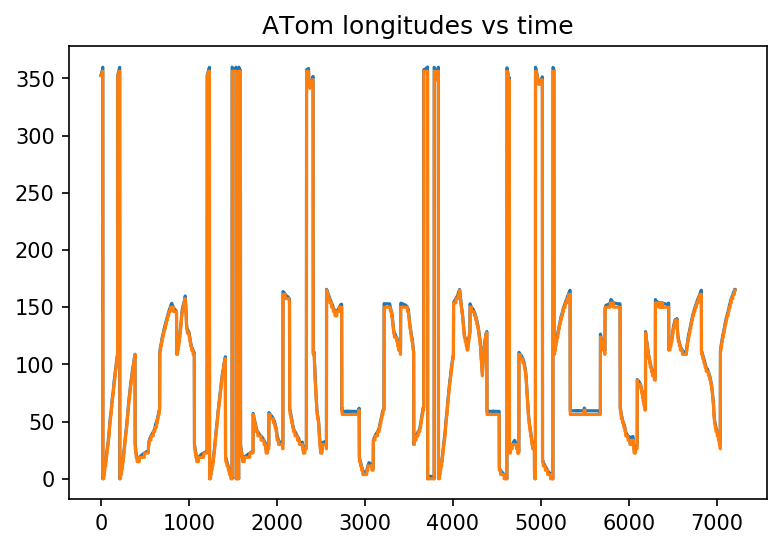

In [130]:
fig = plt.figure(dpi=150)
ax = plt.axes()

x_vals = list(range(len(meas_path)))

plt.plot(x_vals,meas_path.iloc[:,1]+180)
plt.plot(lons_n96)

#ax.set_ylim(-44,-46)
#ax.set_xlim(0,100)

plt.title('ATom longitudes vs time')
#plt.savefig(f'{outfile}/flight_paths_alt.png')
plt.show()

Text(0.5, 1.0, 'ATom measurement range')

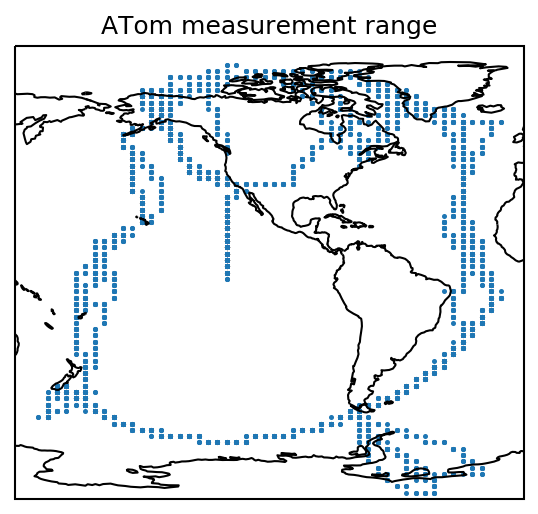

In [132]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#cmap = matplotlib.cm.get_cmap('viridis')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax.coastlines()
plot = ax.scatter(lons_n96,lats_n96,s=2)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Make masked array

In [126]:
#make correct shape array of lats and lons
globe_lats_mod = np.transpose(np.array([mod_lat]*len(mod_lon)))
print(globe_lats_mod.shape)

globe_lons_mod = np.array([mod_lon]*len(mod_lat))
print(globe_lons_mod.shape)

(73, 97)
(73, 97)


In [133]:
meas_loc_n96 = pd.DataFrame({'lon':lons_n96,'lat':lats_n96})

In [151]:
glob_mask_n96 = np.ones((len(mod_lat),len(mod_lon)))

for row in range(len(meas_loc_n96)): 
    #cond = globe_lats == meas_loc.iloc[m,1]) and (globe_lons == meas_loc.iloc[m,0] 
    lat_val = meas_loc_n96.iloc[row,1] 
    lon_val = meas_loc_n96.iloc[row,0] 
    glob_mask1 = ma.masked_where(globe_lats_mod == lat_val,glob_mask_n96) 
    glob_mask2 = ma.masked_where(globe_lons_mod == lon_val,glob_mask_n96) 
    glob_mask3 = ma.masked_where(glob_mask1.mask * glob_mask2.mask, glob_mask_n96) 
    glob_mask_n96 = glob_mask3

In [166]:
inv_mask = ma.masked_where(np.invert(glob_mask_n96.mask),np.ones((len(mod_lat),len(mod_lon))))

In [171]:
np.save(f'{outfile}/ATom_lat_lon_mask.npy',inv_mask.mask)

Text(0.5, 1.0, 'ATom measurement range')

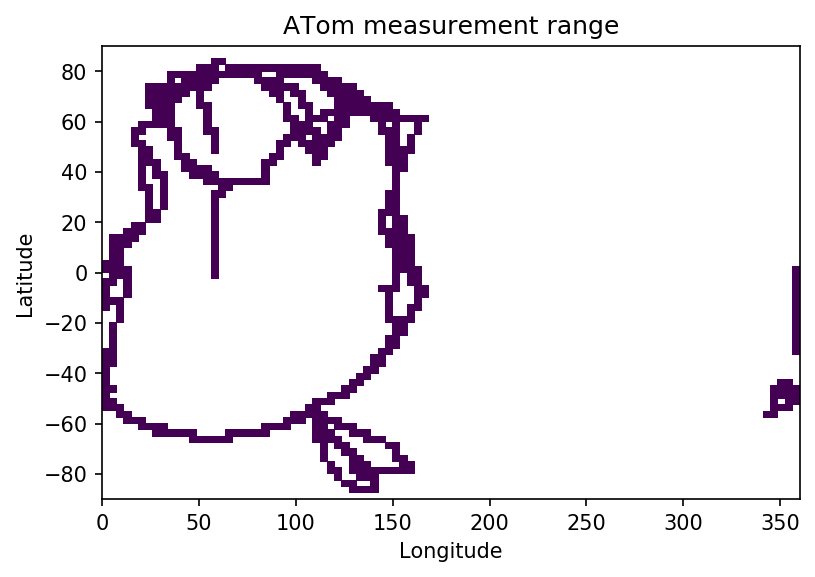

In [169]:
fig = plt.figure(dpi=150)
ax = plt.axes()

#plt.pcolormesh(centr_lons,centr_lats,lat_mask1)
plt.pcolormesh(mod_lon,mod_lat,inv_mask)
#ax.set_xlim(150,180)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ATom measurement range')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')